In [1]:
%matplotlib inline
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import arviz as az
import theano

plt.style.use('seaborn-darkgrid')

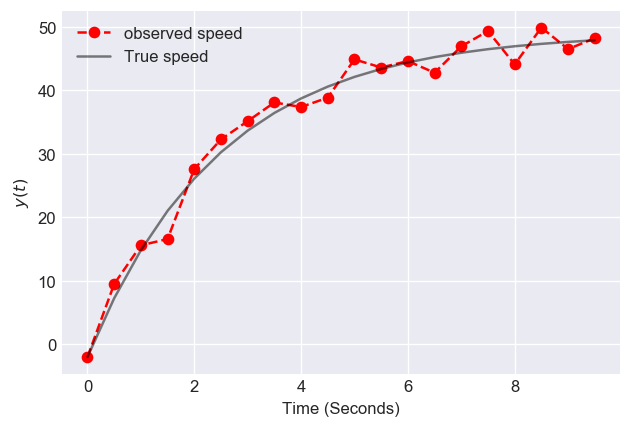

In [2]:
# For reproducibility
np.random.seed(20394)

def freefall(y, t, p):
    return 2.0*p[1] - p[0]*y[0]

# Times for observation
times = np.arange(0,10,0.5)
gamma,g, y0, sigma = 0.4, 9.8, -2, 2
y = odeint(freefall, t=times, y0=y0, args=tuple([[gamma,g]]))
yobs = np.random.normal(y,2)

fig, ax = plt.subplots(dpi=120)
plt.plot(times,yobs, label='observed speed', linestyle='dashed', marker='o', color='red')
plt.plot(times,y, label='True speed', color='k', alpha=0.5)
plt.legend()
plt.xlabel('Time (Seconds)')
plt.ylabel(r'$y(t)$');

In [4]:
ode_model = DifferentialEquation(
    func=freefall,
    times=times,
    n_states=1, n_theta=2,
    t0=0
)

with pm.Model() as model:
    # Specify prior distributions for soem of our model parameters
    sigma = pm.HalfCauchy('sigma',1)
    gamma = pm.Lognormal('gamma',0,1)

    # If we know one of the parameter values, we can simply pass the value.
    ode_solution = ode_model(y0=[0], theta=[gamma, 9.8])
    # The ode_solution has a shape of (n_times, n_states)

    Y = pm.Normal('Y', mu=ode_solution, sd=sigma, observed=yobs)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(2000, tune=1000, cores=1)
    posterior_predictive = pm.sample_posterior_predictive(trace)

    data = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=posterior_predictive)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [gamma, sigma]
100%|██████████| 4000/4000 [00:46<00:00, 86.06it/s]
